# Assignment 1
Linear and circular convolution

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.linalg import toeplitz, circulant, dft
from time import time

plt.rcParams.update({
    "font.serif":["cm"],
    "font.size": 12})

colors = {
    "blue": "#377eb8",
    "orange": "#ff7f00",
    "green": "#4daf4a",
    "pink": "#f781bf",
    "brown": "#a65628",
    "purple": "#984ea3",
    "gray": "#999999",
    "red": "#e41a1c",
    "yellow": "#dede00",
    "black": "#000000",
}

from PIL import Image
import urllib
import io

## Part 1: Starter Exercise

Before using built-in functions, write the convolution function once!

**The Goal:** Implement 1D Linear Convolution (`mode='full'`) in three ways and verify they are identical.
1. **Manual Loops:** To appreciate the computational complexity.
2. **Matrix Algebra:** To leverage linear algebra tools.
3. **Built-in:** To make things more efficient.

In [ ]:
x = [1,2,3,4]
h = [1,1]

conv = x[0]*h[2-0] + x[1] * h[2-1] +x[2]*h[]

In [ ]:
def manual_convolution_loops(x, h, mode='full'):
    """
    Computes convolution y[n] = sum(x[k] * h[n-k]) using nested loops.
    Supports 'full', 'same', and 'valid' modes.
    TODO: Implement the convolution logic here
    """
    # TODO: Initialize output array
    # TODO: Loop over output samples
    # TODO: Handle different modes (full, same, valid)
    sum = 0
    n = len(x)
    m = len(h)
    y = [0] * (n + m - 1)

    for i in range(n):
        for j in range(m):
            y[i + j] += x[i] * h[j]

    if (mode == 'full'):
      return y

    elif (mode == 'same'):
      start = (m - 1) // 2
      return y[start : start + n]

    else:
      if n < m:
          return []
      return y[m-1 : n]
    return y
def test_implementations():
    x = np.array([1, 2, 3, 4, 5])
    h = np.array([1, -1, 2])

    print(f"Input x: {x}")
    print(f"Filter h: {h}")
    print(f"-"*30)

    for mode in ['full', 'same', 'valid']:

        print(f"Mode '{mode}':")
        # 1. Manual Implementation
        t1 = time()
        y_manual = manual_convolution_loops(x, h, mode=mode)
        print(f"Manual Implementation : {time() - t1} sec. \n")
        # 2. Built-in Implementation (Numpy)
        t2 = time()
        y_builtin = np.convolve(x, h, mode=mode)
        print(f"built in Implementation : {time() - t2} sec. \n")


        if np.allclose(y_manual, y_builtin):
            print(f"  Result:   MATCH")
        else:
            print(f"  Result:   MISMATCH")
    print(f"-"*30)

test_implementations()

Input x: [1 2 3 4 5]
Filter h: [ 1 -1  2]
------------------------------
Mode 'full':
Manual Implementation : 2.7179718017578125e-05 sec. 

built in Implementation : 2.288818359375e-05 sec. 

  Result:   MATCH
Mode 'same':
Manual Implementation : 2.384185791015625e-05 sec. 

built in Implementation : 1.1205673217773438e-05 sec. 

  Result:   MATCH
Mode 'valid':
Manual Implementation : 2.2172927856445312e-05 sec. 

built in Implementation : 0.00043463706970214844 sec. 

  Result:   MATCH
------------------------------


## Part 2: Linear Convolution as a Toeplitz Matrix

Now that we understand the loops, we show that convolution is simply a matrix-vector product $y = Ax$.

In [ ]:
import numpy as np
from scipy.linalg import toeplitz

def demo_toeplitz_convolution():
    # Define a simple signal x and filter h
    x = np.array([1, 2, 3, 4])
    h = np.array([1, -1, 2])  # Length 3

    # Standard Numpy Convolve
    y_numpy = np.convolve(x, h, mode='full')
    print(f"Standard Convolution Output: {y_numpy}")

    # Construct Toeplitz matrix
    # First column: h followed by zeros
    # First row: h[0] followed by zeros
    first_col = np.r_[h, np.zeros(len(x) - 1)]
    first_row = np.r_[h[0], np.zeros(len(x) - 1)]
    H_mat = toeplitz(first_col, first_row)

    print("\nToeplitz Convolution Matrix (H):")
    print(H_mat)

    # Perform matrix multiplication
    y_matrix = H_mat @ x
    print(f"\nMatrix Multiplication Output: {y_matrix}")

    assert np.allclose(y_numpy, y_matrix), "Mismatch between numpy and matrix method!"

demo_toeplitz_convolution()


def demo_circulant_matrix():
    x = np.array([1, 2, 3, 4])
    h = np.array([1, 0, -1, 0])  # Same length as x for circular conv

    N = len(h)

    # Create circulant matrix from h
    C = np.zeros((N, N))
    for i in range(N):
        C[i] = np.roll(h, i)

    print("\nCirculant Matrix C:")
    print(C)

    # Compare matrix multiplication with FFT-based circular convolution
    y_matrix = C @ x
    y_fft = np.fft.ifft(np.fft.fft(x) * np.fft.fft(h)).real

    print(f"\nMatrix Result: {y_matrix}")
    print(f"FFT Result: {y_fft}")

    assert np.allclose(y_matrix, y_fft), "Mismatch between matrix and FFT methods!"

demo_circulant_matrix()


## Part 3: Audio De-reverberation (1D Application)

Use the functions to construct reverberated audio and perform de-reverberation
* **Model:** Room impulse response
* **Input:** Standard speech file
* **Restoration:** Inverse/Wiener filter

In [3]:
import scipy.io.wavfile as wavfile
import urllib.request
import io

In [15]:
def get_audio_sample():
    """Downloads a standard wav file or generates a fallback."""
    url = "https://www.signalogic.com/melp/EngSamples/Orig/male.wav"
    try:
        print(f"Attempting to download audio from {url}...")
        response = urllib.request.urlopen(url)
        data = response.read()
        sr, y = wavfile.read(io.BytesIO(data))
        # Normalize to -1..1
        y = y.astype(float) / np.max(np.abs(y))
        # Take a 3-second slice to keep processing fast
        y = y[:sr*3]
        print("Download successful.")
        return sr, y
    except Exception as e:
        print(f"Download failed: {e}. Generating fallback audio.")

In [16]:
def create_room_impulse_response(sr):
    """Creates a synthetic Room Impulse Response (Echo)."""
    # A decaying exponential with random spikes
    T_echo = 0.3 # 300ms reverb
    n_echo = int(sr * T_echo)
    t = np.linspace(0, T_echo, n_echo)

    # Exponential decay envelope
    envelope = np.exp(-10 * t)

    # Random reflections
    noise = np.random.randn(n_echo)
    rir = noise * envelope

    # Normalize energy
    rir = rir / np.sqrt(np.sum(rir**2))
    return rir

In [17]:
import numpy as np

def wiener_deconvolution(observed, kernel, K):
    """
    Apply Wiener Deconvolution in the frequency domain.

    Parameters:
    observed : 1D numpy array
        Observed (noisy) audio signal
    kernel : 1D numpy array
        Degradation kernel / impulse response
    K : float
        Noise-to-signal power ratio (regularization parameter)

    Returns:
    recovered : 1D numpy array
        Denoised audio signal
    """
    # Pad kernel to match signal length
    n = len(observed)
    kernel_padded = np.zeros(n)
    kernel_padded[:len(kernel)] = kernel

    # FFT of observed signal and kernel
    Y = np.fft.fft(observed)
    H = np.fft.fft(kernel_padded)

    # Wiener filter: H* / (|H|^2 + K)
    H_conj = np.conj(H)
    H_abs_sq = np.abs(H) ** 2
    H_hat = H_conj / (H_abs_sq + K)

    # Apply filter and inverse FFT
    X_hat = H_hat * Y
    recovered = np.real(np.fft.ifft(X_hat))

    return recovered


In [18]:
# 1. Setup
sr, clean_speech = get_audio_sample()
rir = create_room_impulse_response(sr)

# 2. Simulate "The Room" (Convolution)
reverbed_speech = np.convolve(clean_speech, rir, mode='same')

# 3. Add Noise (The "Hiss")
noise_level = 0.02
noise = np.random.randn(len(reverbed_speech)) * noise_level
observed_signal = reverbed_speech + noise

# 4. Attempt Recovery
recovered_naive = wiener_deconvolution(observed_signal , rir, 0)
recovered_wiener = wiener_deconvolution(observed_signal, rir , 10)

Attempting to download audio from https://www.signalogic.com/melp/EngSamples/Orig/male.wav...
Download successful.


TypeError: Figure.savefig() missing 1 required positional argument: 'fname'

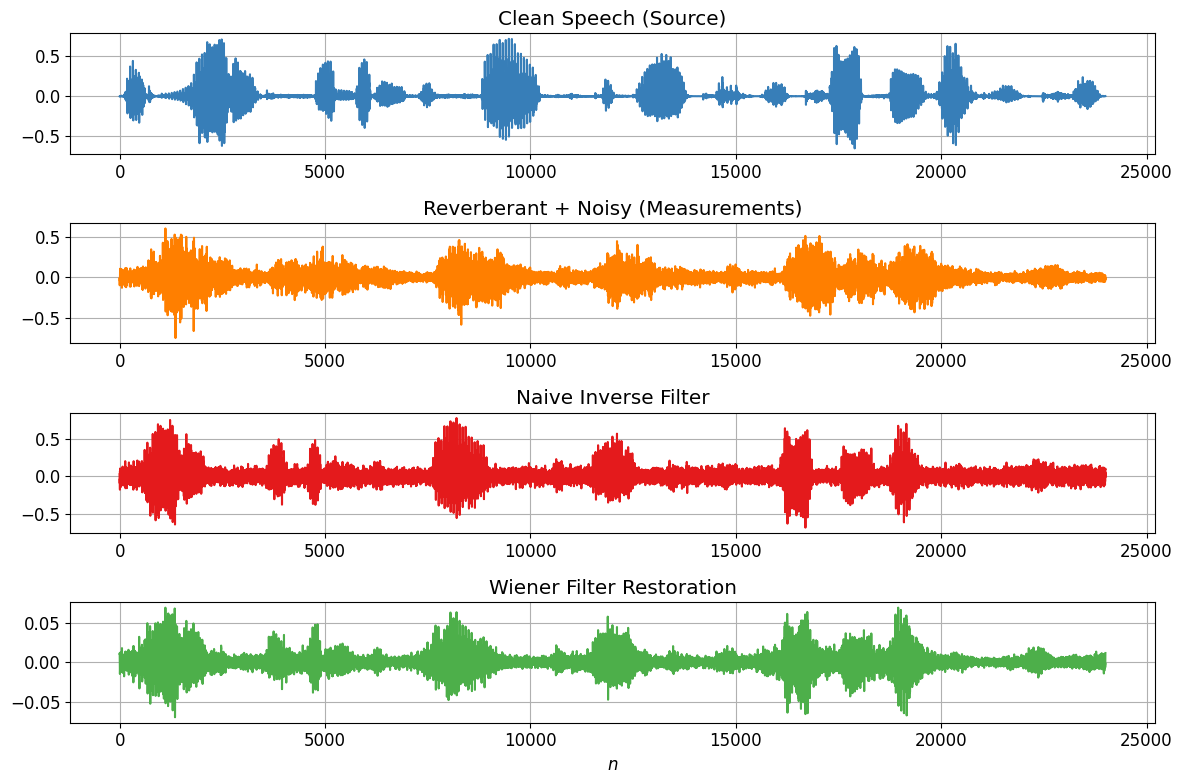

In [19]:
# 5. Visualization
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.title("Clean Speech (Source)")
plt.plot(clean_speech, color=colors['blue'])
plt.grid(True)

plt.subplot(4, 1, 2)
plt.title("Reverberant + Noisy (Measurements)")
plt.plot(observed_signal, color=colors['orange'])
plt.grid(True)

plt.subplot(4, 1, 3)
plt.title("Naive Inverse Filter")
plt.plot(recovered_naive, color=colors['red'])
plt.grid(True)

plt.subplot(4, 1, 4)
plt.title("Wiener Filter Restoration")
plt.plot(recovered_wiener, color=colors['green'])
plt.grid(True)
plt.xlabel("$n$")

plt.tight_layout()
plt.savefig()
plt.savefig("op_files/task_4/task_4.png")
plt.show()

In [9]:
import IPython.display as ipd

print("1. Clean Speech")
ipd.display(ipd.Audio(clean_speech, rate=sr))

print("2. Reverberant + Noisy")
ipd.display(ipd.Audio(observed_signal, rate=sr))

print("3. Naive Inverse Filter")
ipd.display(ipd.Audio(recovered_naive, rate=sr))

print("4. Wiener Restored")
ipd.display(ipd.Audio(recovered_wiener, rate=sr))

1. Clean Speech


2. Reverberant + Noisy


3. Naive Inverse Filter


4. Wiener Restored


## Part 4/5: 2D Image Deblurring (Set5 & Levin Kernels)

We apply the same Wiener Filter logic to images.
* **Gaussian Blur:** Simulates out-of-focus lens.
* **Motion Blur:** Simulates camera shake (Levin-like kernels).
* **Inverse Filter:** Fails due to zeros in the blur kernel.
* **Wiener Filter:** Restores structure by regularizing the inversion.

In [20]:
from PIL import Image
import urllib
import io
def get_image_sample():
    """Downloads 'baby.png' from Set5."""
    url = "https://raw.githubusercontent.com/jbhuang0604/SelfExSR/master/data/Set5/image_SRF_4/img_001_SRF_4_HR.png"
    try:
        print(f"Downloading Set5 image from {url}...")
        with urllib.request.urlopen(url) as response:
            data = response.read()
        img = Image.open(io.BytesIO(data)).convert('L') # Convert to Grayscale
        img = np.array(img).astype(float) / 255.0
        print("Download successful.")
        return img
    except Exception as e:
        print(f"Download failed ({e}). Generating synthetic text image...")

In [21]:
import numpy as np

def get_gaussian_kernel(size=15, sigma=3):

    assert size % 2 == 1, "Kernel size must be odd"

    # Create coordinate grid centered at zero
    ax = np.arange(-(size // 2), size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)

    # Compute Gaussian function
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))

    # Normalize kernel so sum equals 1
    kernel /= np.sum(kernel)

    return kernel


def get_motion_kernel(size=15, angle=45):
    """Generates a Motion Blur Kernel (Line)."""
    kernel = np.zeros((size, size))
    # Draw a line in the center using a simple algorithm
    center = size // 2
    slope = np.tan(np.deg2rad(angle))
    for x in range(size):
        offset = int((x - center) * slope)
        y = center - offset
        if 0 <= y < size:
            kernel[y, x] = 1.0
    return kernel / np.sum(kernel)

In [22]:
import numpy as np

def wiener_deconvolution_2d(img_blurred, kernel, K):
    """
    Performs 2D Wiener Deconvolution in the frequency domain.
    """
    h, w = img_blurred.shape
    kh, kw = kernel.shape

    # Normalize kernel
    kernel = kernel / np.sum(kernel)

    # Pad kernel to image size with centering
    kernel_padded = np.zeros((h, w))
    y0 = (h - kh) // 2
    x0 = (w - kw) // 2
    kernel_padded[y0:y0 + kh, x0:x0 + kw] = kernel

    # Shift kernel so that center is at (0,0)
    kernel_padded = np.fft.ifftshift(kernel_padded)

    # FFTs
    G = np.fft.fft2(img_blurred)
    H = np.fft.fft2(kernel_padded)

    # Wiener filter
    H_conj = np.conj(H)
    W = H_conj / (np.abs(H) ** 2 + K)

    # Apply filter
    F_hat = W * G
    img_restored = np.real(np.fft.ifft2(F_hat))

    return img_restored


In [23]:
# 1. Setup Data
img = get_image_sample()
k_motion = get_motion_kernel(size=15, angle=30)
print(type(img))
# 2. Simulate Degradation
# We use fftconvolve for accurate boundary handling (or standard convolve2d)
img_blurred = scipy.signal.convolve2d(img, k_motion, mode='same', boundary='wrap')

# 3. Add Noise
noise_sigma = 0.01  # Gaussian noise
noise = np.random.randn(*img.shape) * noise_sigma
img_degraded = img_blurred + noise

# 4. Restoration
# K should be approx (Noise Power / Signal Power) or tuned manually
# Try K=0 for Inverse Filter (will explode)
img_inverse = wiener_deconvolution_2d(img_degraded, k_motion, K=1e-12)
# Try Tuned K for Wiener
K = 1e-2
img_wiener = wiener_deconvolution_2d(img_degraded, k_motion, K=K)

Download successful.
<class 'numpy.ndarray'>


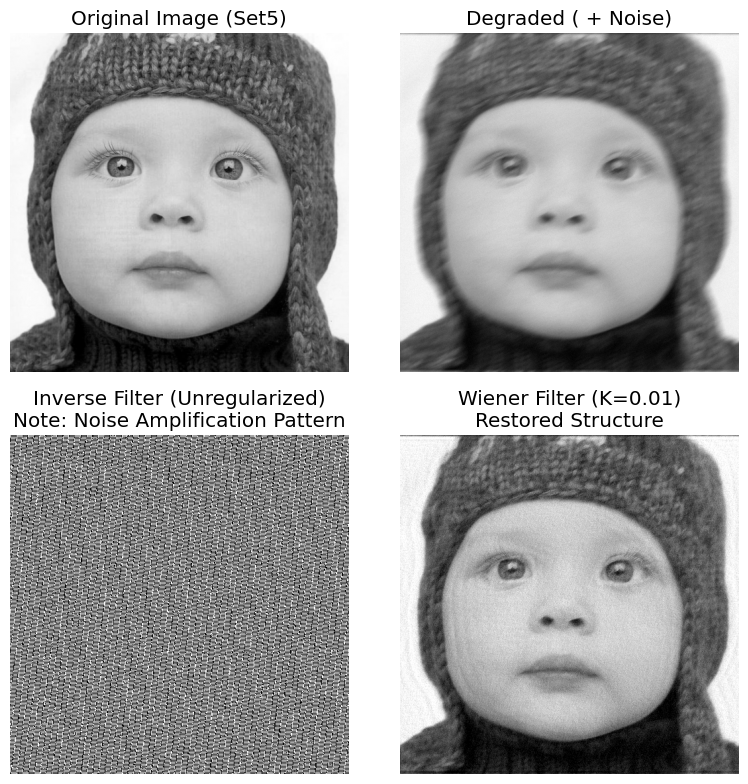

In [24]:
# 5. Visualization
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.title("Original Image (Set5)")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title(f"Degraded ( + Noise)")
plt.imshow(img_degraded, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Inverse Filter (Unregularized)\nNote: Noise Amplification Pattern")
plt.imshow(np.clip(img_inverse, 0, 1), cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title(f"Wiener Filter (K={K})\nRestored Structure")
plt.imshow(np.clip(img_wiener, 0, 1), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.savefig("op_files/task_5/task_4_5.png")
plt.show()

## Part 6: Blind Deconvolution

- **Observation:** Motion blur, "unknown"
- **Restoration:** Parametrize the kernel as Gaussian and find parameters

In [25]:
def get_mystery_image():
    """Loads the 'Page' image."""
    try:
        print(f"Loading mystery image from local file...")
        img = Image.open("ip_files/page.png").convert('L')
        img = np.array(img).astype(float) / 255.0

        return img
    except Exception as e:
        print(f"Failed to load.")

In [26]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return 100
    return 10 * np.log10(1.0 / mse)

# 1. Prepare the
gt_img = get_mystery_image()
print(type(gt_img))
# mystery_sigma = 2.4
# mystery_kernel = get_gaussian_kernel(size=21, sigma=mystery_sigma)
mystery_kernel = get_motion_kernel(size=7, angle=30)
mystery_blur = scipy.signal.convolve2d(gt_img, mystery_kernel, mode='same', boundary='wrap')
mystery_noise = np.random.randn(*gt_img.shape) * 0.02
mystery_observed = mystery_blur + mystery_noise

Loading mystery image from local file...
<class 'numpy.ndarray'>


Optimal parameters:
  Gaussian kernel size : 9
  Gaussian sigma       : 2.0
  Wiener constant K    : 0.05
  PSNR                 : 18.43 dB


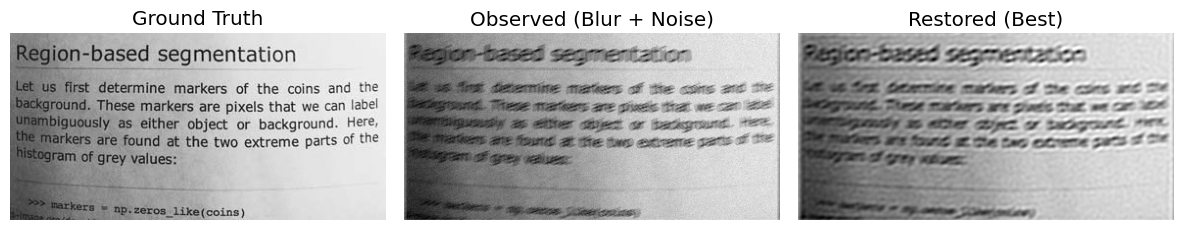

In [27]:
kernel_sizes = [3, 5, 7, 9, 13, 17, 21]
sigmas = [1.5, 1.8, 1.9,2.0,2.1, 2.2, 2.5, 3.0, 3.5]
Ks = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]

best_psnr = -np.inf
best_params = None
best_restored = None

for size in kernel_sizes:
    for sigma in sigmas:
        kernel_est = get_gaussian_kernel(size=size, sigma=sigma)

        for K in Ks:
            restored = wiener_deconvolution_2d(
                mystery_observed, kernel_est, K
            )

            # Clip to valid image range
            restored = np.clip(restored, 0, 1)

            psnr = calculate_psnr(gt_img, restored)

            if psnr > best_psnr:
                best_psnr = psnr
                best_params = (size, sigma, K)
                best_restored = restored


# -----------------------
# Report results
# -----------------------
print("Optimal parameters:")
print(f"  Gaussian kernel size : {best_params[0]}")
print(f"  Gaussian sigma       : {best_params[1]}")
print(f"  Wiener constant K    : {best_params[2]}")
print(f"  PSNR                 : {best_psnr:.2f} dB")


# -----------------------
# Display results
# -----------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Ground Truth")
plt.imshow(gt_img, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Observed (Blur + Noise)")
plt.imshow(mystery_observed, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Restored (Best)")
plt.imshow(best_restored, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.savefig("op_files/task_6/task_6.png")
plt.show()
